# Compare distribution of kinematics during high dopamine and low dopamine syllable instances

In [1]:
import toml
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from rl_analysis.io.df import load_dlight_features, dlight_exclude_toml
from rl_analysis.plotting import save_factory, setup_plotting_env, subplots
from scipy import stats

warnings.simplefilter('ignore')

In [2]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'ppe-fig'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

In [3]:
use_dct = dlight_exclude_toml(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.toml'),
    **config["dlight_common"]
)

In [4]:
feat_df = load_dlight_features('/home/wg41/reinforcement_data/public-dataset/dlight-chrimson_snippets_offline_features.parquet')
feat_df = feat_df[feat_df['uuid'].isin(list(use_dct))]

feat_df['velocity_2d_mm'] *= 30
feat_df['acceleration_2d_mm'] *= 30
feat_df['velocity_angle'] *= 30
feat_df['velocity_height'] *= 30

In [5]:
syllables = [5, 19]

bin 1 sample size: 7625
bin 4 sample size: 7620


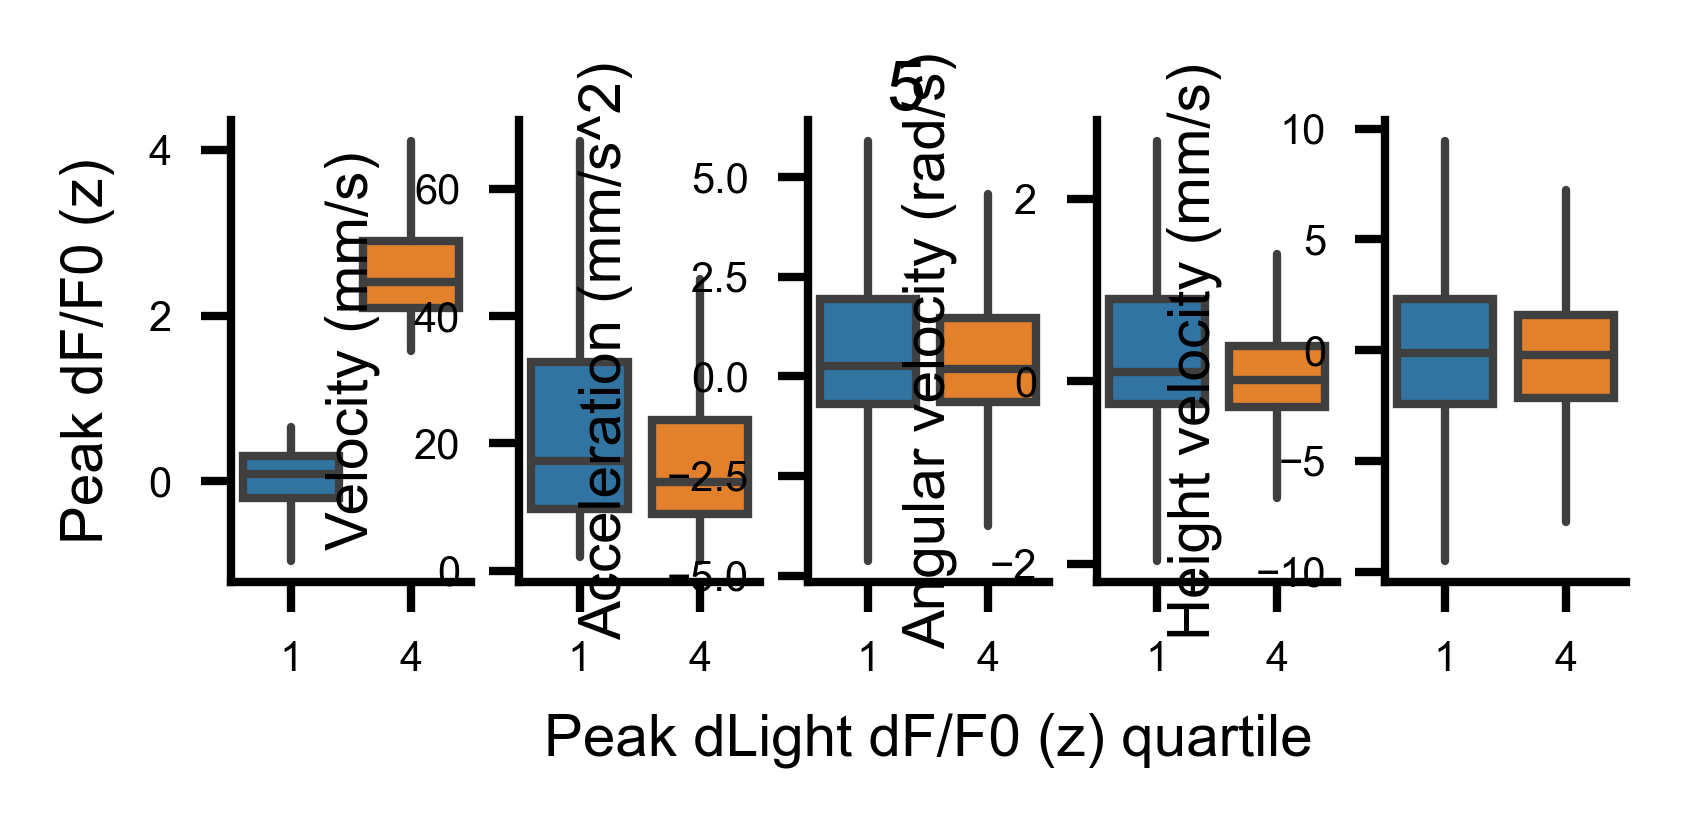

bin 1 sample size: 5920
bin 4 sample size: 5918


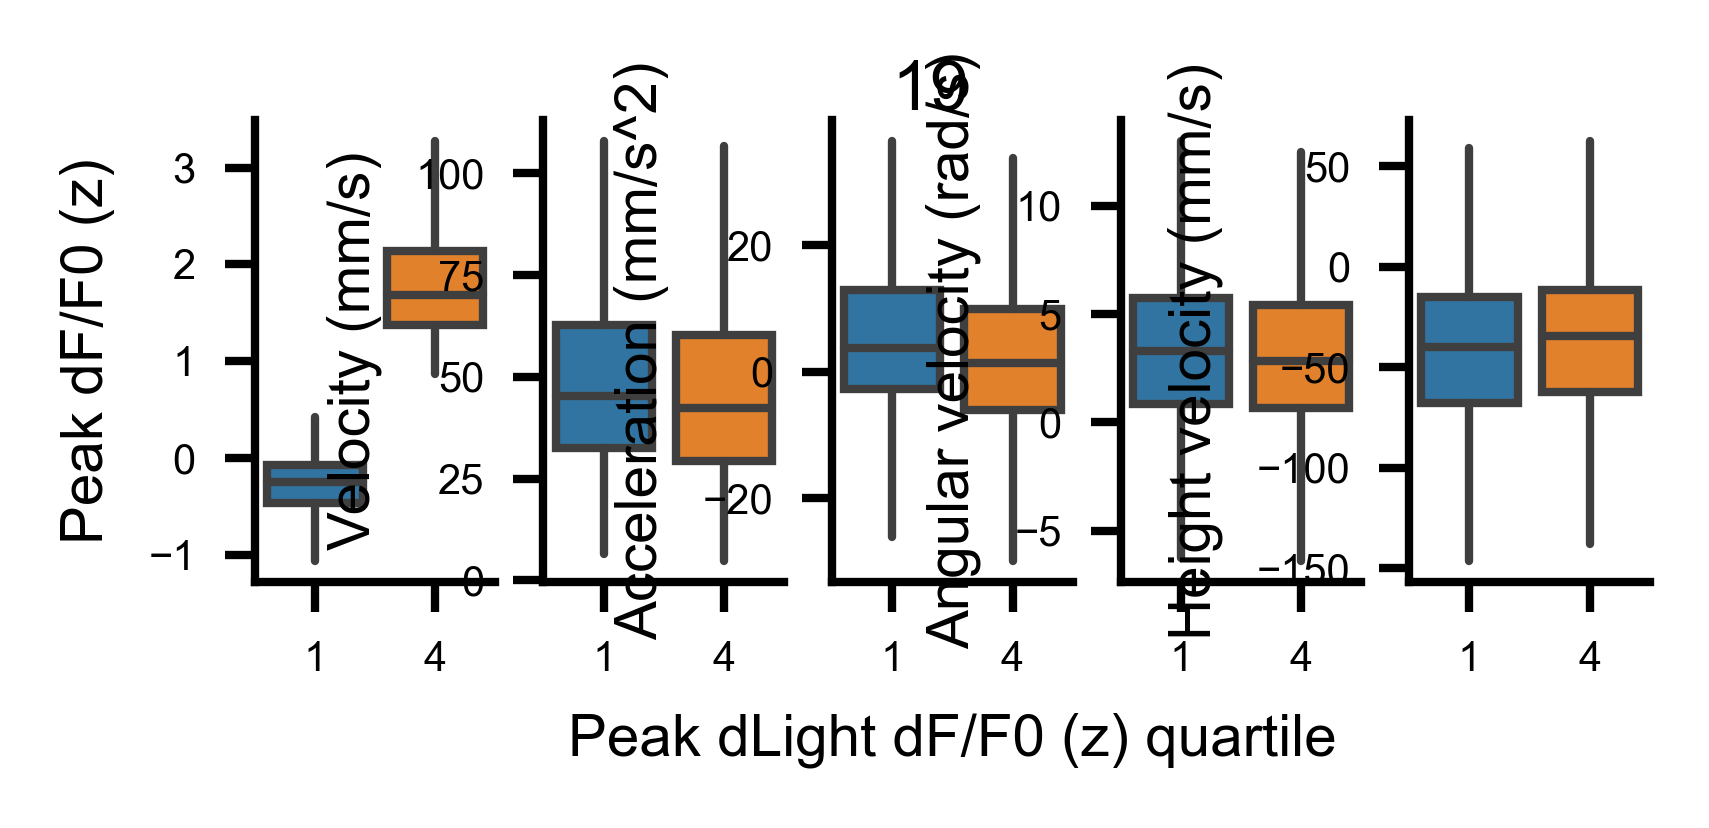

In [6]:
y_map = dict(
    signal_reref_dff_z_max="Peak dF/F0 (z)",
    velocity_2d_mm="Velocity (mm/s)",
    acceleration_2d_mm="Acceleration (mm/s^2)",
    velocity_angle="Angular velocity (rad/s)",
    velocity_height="Height velocity (mm/s)",
)

stat_dicts = {}
for s in syllables:
    sample = feat_df[feat_df["syllable"] == s].copy()
    sample["peak_bin"] = sample.groupby("mouse_id", observed=True)["signal_reref_dff_z_max"].apply(
        lambda d: pd.qcut(d, 4, labels=False)
    )
    print('bin 1 sample size:', len(sample.query('peak_bin == 0')))
    print('bin 4 sample size:', len(sample.query('peak_bin == 3')))

    fig, ax = subplots(1, 5, 3, 1)
    for key, a in zip(y_map, ax.flat):
        sns.boxplot(
            data=sample, y=key, x="peak_bin", order=[0, 3], showfliers=False, showcaps=False, ax=a
        )
        a.set(ylabel=y_map[key], xlabel="", xticklabels=[1, 4])
    ax[len(ax) // 2].set(xlabel="Peak dLight dF/F0 (z) quartile")
    sns.despine()
    saver(fig, f"syllable-{s}-kinematic-comparison")
    fig.suptitle(s)
    plt.show()
    stat_dict = {}
    for key in y_map:
        tmp = sample.dropna(subset=[key])
        _stat = stats.mannwhitneyu(
            tmp.loc[tmp["peak_bin"] == 0, key],
            tmp.loc[tmp["peak_bin"] == 3, key],
        )
        stat_dict[key] = _stat
    stat_dicts[s] = stat_dict

In [7]:
stat_dicts

{5: {'signal_reref_dff_z_max': MannwhitneyuResult(statistic=0.0, pvalue=0.0),
  'velocity_2d_mm': MannwhitneyuResult(statistic=33238752.0, pvalue=1.3510272333827077e-53),
  'acceleration_2d_mm': MannwhitneyuResult(statistic=30025160.5, pvalue=0.0003376658758588436),
  'velocity_angle': MannwhitneyuResult(statistic=32083449.0, pvalue=1.0772434399481501e-36),
  'velocity_height': MannwhitneyuResult(statistic=29989238.5, pvalue=0.0005557637012235388)},
 19: {'signal_reref_dff_z_max': MannwhitneyuResult(statistic=0.0, pvalue=0.0),
  'velocity_2d_mm': MannwhitneyuResult(statistic=18771700.0, pvalue=1.506610632787239e-11),
  'acceleration_2d_mm': MannwhitneyuResult(statistic=19816278.0, pvalue=4.0005660011484397e-35),
  'velocity_angle': MannwhitneyuResult(statistic=17980508.5, pvalue=0.00020161401141828176),
  'velocity_height': MannwhitneyuResult(statistic=16360038.5, pvalue=4.829122607920983e-10)}}

In [ ]:
7625 + 7620

15245

In [ ]:
5920 + 5918

11838